# This test doesn't use any labels at all, but evaluates models on their false positive and false negative rates after predictions are made. 
1. Make predictions on a recording
2. look at the model predictions sorted by confidence. 
3. Count the false positives and false negatives within these predictions. 

In [19]:
# imports
from pathlib import Path
import sys
import shutil
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
model_save_path = BASE_PATH / 'models'
import pandas as pd
import opensoundscape as opso
from opensoundscape import audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import interact
import glob
from src.utils import  show_samples_in_df, get_binary_targets_scores, suppress_warnings_if_main_branch, plot_metrics_across_thresholds, hawkears_files_to_df, plot_confusion_matrix, save_dataframe_clips_to_disk, show_sample_from_df, show_clip_from_multi_index_df, inspect_wrong_predictions

In [3]:
# load the test data
data_path = Path.cwd().parent.parent / "data"
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "test_set.pkl")
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)

In [5]:
# Load the target species examples from the external test set
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)
# filter out all the other species
osfls = ext_df.loc[ext_df.species_code == "OSFL"]
# filter out the target species calls and keep the songs. 
osfls = osfls.loc[osfls.vocalization == "Song"]

In [18]:
recording_save_path = data_path / "raw" / "recordings" / "OSFL"
external_test_set_recordings = data_path / "processed" / "external_test_set_recordings"

def get_file_extension(url):
    file_type = url.split('.')[-1]
    return file_type
def make_filename(df):
    
    return f"recording-{df.recording_id}.{df.file_type}"

osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
osfls['filename'] = osfls.apply(make_filename, axis=1)
external_test_set_filenames = osfls.filename.unique()
len(external_test_set_filenames), external_test_set_filenames

(39,
 array(['recording-255472.flac', 'recording-255412.mp3',
        'recording-255913.flac', 'recording-255938.flac',
        'recording-255940.flac', 'recording-255949.flac',
        'recording-255967.flac', 'recording-255980.flac',
        'recording-255420.mp3', 'recording-255419.mp3',
        'recording-255421.mp3', 'recording-255431.mp3',
        'recording-255432.mp3', 'recording-255433.mp3',
        'recording-255449.mp3', 'recording-255456.mp3',
        'recording-255454.mp3', 'recording-255457.mp3',
        'recording-255461.mp3', 'recording-255465.mp3',
        'recording-255539.flac', 'recording-255544.flac',
        'recording-255497.mp3', 'recording-255513.mp3',
        'recording-255518.mp3', 'recording-255526.mp3',
        'recording-255623.flac', 'recording-255624.flac',
        'recording-255625.flac', 'recording-255580.mp3',
        'recording-255581.mp3', 'recording-255582.mp3',
        'recording-255649.flac', 'recording-255607.mp3',
        'recording-255665.mp3'

In [20]:
external_test_set_recordings.mkdir(parents=True, exist_ok=True)
for file in external_test_set_filenames:
    source = recording_save_path / file
    destination = external_test_set_recordings / file
    shutil.copy(source, destination)
    print(f"copied {source} to {destination}")
    

copied /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-255472.flac to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings/recording-255472.flac
copied /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-255412.mp3 to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings/recording-255412.mp3
copied /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-255913.flac to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings/recording-255913.flac
copied /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw/recordings/OSFL/recording-255938.flac to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings/recording-255938.flac
copied /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/raw

In [22]:
model = opso.load_model(model_save_path / "OSFL.model")

In [25]:
external_test_set_recordings

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings')

39 of these, 782.2mb <br>
Took 11 min 31 seconds to process with OSFL recognizer on 1 CPU core

# Check the results

In [44]:
osfl_model_predictions = pd.read_csv(BASE_PATH / "OSFL-scores.csv").sort_values(by="target_present", ascending=False)

<Axes: >

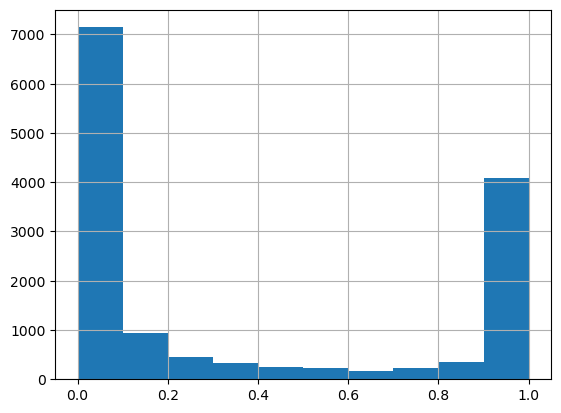

In [47]:
osfl_model_predictions.target_present.hist()

In [54]:
hawkears_output_files = glob.glob(str(data_path / "processed" / "hawkears" / "*.*"))

In [60]:
results = []
# Read and parse the file contents
for file_path in hawkears_output_files:
    with open(file_path, "r") as f:
        file_content = f.read().strip().split("\n")
        file_id = file_path.split("/")[-1].split("-")[0]
        file_id = file_id.split("_")[0]
        for detection in file_content:
            if detection:
                line = [file_id] + detection.split("\t")
            else:
                line = [file_id]
            results.append(line)

# Convert the results to a pandas DataFrame
df = pd.DataFrame(
    results, columns=["file_id", "start_time", "end_time", "species;confidence"]
)



end_time
600.00    3672
300.00    1224
372.00     306
312.00     306
Name: count, dtype: int64

In [ ]:

df.file_id = df.file_id.astype(int)
df.sort_values(by=["file_id"], inplace=True)
df[["species", "confidence"]] = df["species;confidence"].str.split(";", expand=True)
df.drop(columns=["species;confidence"], inplace=True)
df = df.loc[df["species"] == target_species]
df.confidence = df.confidence.astype(float)
return df.reset_index(drop=True)